In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from scipy.misc import derivative
import time

In [2]:
data= pd.read_csv("Lanczos1 Data.txt",names=['y','x'], sep=" ")

data

,y,x
NaN,2.513400,0.00
NaN,2.044333,0.05
NaN,1.668404,0.10
NaN,1.366418,0.15
NaN,1.123232,0.20
NaN,0.926890,0.25
NaN,0.767934,0.30
NaN,0.638878,0.35
NaN,0.533784,0.40
NaN,0.447936,0.45


In [3]:
y = torch.from_numpy(data['y'].to_numpy(np.float64))
x = torch.from_numpy(data['x'].to_numpy(np.float64))

# b = torch.tensor([1.2,0.3,5.6,5.5,6.5,7.6],requires_grad=True)
b = torch.tensor([0.5,0.7,3.6,4.2,4.0,6.3],requires_grad=True)

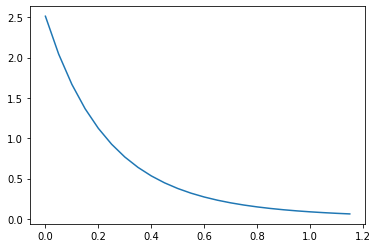

In [4]:
plt.plot(x.numpy(),y.numpy())

In [5]:
def Jacobian(loss,params,numParams):
    
    jacobian = torch.empty(len(loss), numParams) 
    
    for i in range(len(loss)):
        
        loss[i].backward(retain_graph=True)
        
        for n in range(numParams):
            jacobian[i][n] = params.grad[n]
        params.grad.zero_()      
    return jacobian    

In [6]:
## Numerical Differentiation

b = np.array([1.2,0.3,5.6,5.5,6.5,7.6]).reshape(-1,1)
# b = np.array([0.5,0.7,3.6,4.2,4.0,6.3]).reshape(-1,1)

x=x.detach().numpy()

u=0.1 #beta multiply identity matrix
beta = 10
V_prev = 0



def f0(b0):
    return b0*np.exp((-b[1]*x)) + b[2]*np.exp((-b[3]*x)) + b[4]*np.exp((-b[5]*x))-y.detach().numpy()  
def f1(b1):
    return b[0]*np.exp((-b1*x)) + b[2]*np.exp((-b[3]*x)) + b[4]*np.exp((-b[5]*x))-y.detach().numpy()  
def f2(b2):
    return b[0]*np.exp((-b[1]*x)) + b2*np.exp((-b[3]*x)) + b[4]*np.exp((-b[5]*x))-y.detach().numpy()  
def f3(b3):
    return b[0]*np.exp((-b[1]*x)) + b[2]*np.exp((-b3*x)) + b[4]*np.exp((-b[5]*x))-y.detach().numpy()  
def f4(b4):
    return b[0]*np.exp((-b[1]*x)) + b[2]*np.exp((-b[3]*x)) + b4*np.exp((-b[5]*x))-y.detach().numpy()  
def f5(b5):
    return b[0]*np.exp((-b[1]*x)) + b[2]*np.exp((-b[3]*x)) + b[4]*np.exp((-b5*x))-y.detach().numpy()  

for c in range(500):
    start_time = time.time()
    y_pred = b[0]*np.exp((-b[1]*x)) + b[2]*np.exp((-b[3]*x)) + b[4]*np.exp((-b[5]*x))  
    error = (y_pred - y.detach().numpy()).reshape(-1,1)
    
    d_b0 = derivative(f0,b[0] , dx=1e-6)
    d_b1 = derivative(f1,b[1] , dx=1e-6)
    d_b2 = derivative(f2,b[2] , dx=1e-6)
    d_b3 = derivative(f3,b[3] , dx=1e-6)
    d_b4 = derivative(f4,b[4] , dx=1e-6)
    d_b5 = derivative(f5,b[5] , dx=1e-6)
     
    jacobian = np.transpose(np.array([d_b0,d_b1,d_b2,d_b3,d_b4,d_b5]))
    dParam = np.matmul(np.matmul(np.linalg.inv((np.matmul(np.transpose(jacobian),jacobian)+u*np.identity(len(b)))),np.transpose(jacobian)),error)
    b -= dParam
    V = np.sum(np.square(error))
    if(V > V_prev):
            u *= beta
    else:
            u /= beta
    V_prev = V
    print("c: ",c," error: ",V," B:", b)
    
    if V < 1.4307867721E-25:
        break
print("time taken to execute: ",time.time()-start_time)  

c:  0  error:  269.75037483661  B: [[-0.22996363]
 [-0.02157119]
 [ 1.18181914]
 [ 4.4810285 ]
 [ 1.88506849]
 [ 7.4159447 ]]
time taken to execute:  0.005984067916870117


In [7]:
def Jacobian_numerical(dParams,num_instances):
    jacobian = np.empty(num_instances,len(dParams))
    for i in range(num_instances):
        
        for n in range(dParams):
            jacobian[i][n] = dParams[i][n]
     
    return jacobian   

In [9]:
## Automatic Differentiation
num_param = len(b)
u=0.1 #beta multiply identity matrix
beta = 10
error_prev = 0
for c in range(500):
    
    y_pred = b[0]*torch.exp((-b[1]*x)) + b[2]*torch.exp((-b[3]*x)) + b[4]*torch.exp((-b[5]*x))  
    
    loss = y_pred-y
    error = torch.sum(torch.square(loss)) #residual sum of squares
    print("",c," error is: ",error.detach().numpy()," b is ", b.detach().numpy())
    jacobian = Jacobian(loss,b,len(b))

    dParam = torch.matmul(torch.matmul(torch.inverse(torch.matmul(torch.transpose(jacobian,-1,0),jacobian)+u*torch.eye(num_param, num_param)),torch.transpose(jacobian,-1,0)),loss.float())
    with torch.no_grad():
        b -=dParam
    
        if(error > error_prev):
            u *= beta
        else:
            u /= beta
        error_prev = error
    if error<1.4307867721E-25: #3.9050739624 given residual sum of squares
        break
    

TypeError: exp(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
plt.plot(y_pred.detach(),'g.', y,'r')